In [1]:
import pickle
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

/data/nasif12/home_if12/l_schewinski/.conda/envs/l-schewinski-tp-4/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import ast

# Get protein sequence, peptide sequence, and binary positions from file for specific protein/peptide

df_2 = pd.read_csv('data/OsmoticStress_with_binary_positions_padded.csv')
df_2 = df_2.drop(columns=[ 'Padded_Binary_Positions'])
df_2_P32485 = df_2[df_2["Uniprot_ID"] == "P32485"]
df_2_P32485['full_sequence_len'] = df_2_P32485['full_sequence'].apply(len)
df_2_P32485_HOG1 = df_2_P32485.iloc[:1]
df_2_P32485_HOG1

protein_sequence = df_2_P32485_HOG1.iloc[0,3]
print(len(protein_sequence))
peptide_sequence = df_2_P32485_HOG1.iloc[0,1]
print(len(peptide_sequence))

binary_position_extracted = df_2_P32485_HOG1.iloc[0, 4]
binary_position_list = ast.literal_eval(binary_position_extracted)
print(len(binary_position_list))

435
13
435


/data/nasif12/home_if12/l_schewinski/.conda/envs/l-schewinski-tp-4/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [3]:
# Define device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "CPU")

# Load specific embeddings for mutatate proteins
def load_and_process_embedding(file_path):
    """
    Loads the embeddings from a file and returns a DataFrame.
    """
    with open(file_path, 'rb') as file:
        embeddings = pickle.load(file)
    return pd.DataFrame(embeddings)

embedding_files = [
    'data/mutant_sequences_50_context_fix_1.pkl',
    'data/mutant_sequences_50_context_fix_2.pkl'
]

mutant_embeddings = pd.DataFrame()

for file_path in embedding_files:
    current_mutant_embeddings = load_and_process_embedding(file_path)
    mutant_embeddings = pd.concat([mutant_embeddings, current_mutant_embeddings])

# Trim embeddings first and last token
mutant_embeddings['trim_embeddings'] = mutant_embeddings['embeddings'].apply(lambda x: np.array(x)[1:-1, :])

mutant_embeddings = mutant_embeddings[['Position', 'Substituted_AA', 'trim_embeddings']]

# Model definition
class PeptideRegressor(nn.Module):
    def __init__(self, input_dim, num_heads, dropout_rate):
        super(PeptideRegressor, self).__init__()

        self.fc_embed = torch.nn.Linear(1280, 256)
        
        self.seq_pos_embed = nn.Embedding(1000, 1280)
        self.pept_pos_embed = nn.Embedding(2, 1280)
        
        self.norm = nn.LayerNorm(input_dim)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=256, 
            nhead=num_heads, 
            dropout=dropout_rate
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)
        
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(256, 1)

    def forward(self, x):
        positions = x["position"]
        x = x["embeddings"] + self.seq_pos_embed(torch.arange(x["position"].size(1), device=device)) + self.pept_pos_embed(x["position"])
        x = x.permute(1, 0, 2)

        embed = self.fc_embed(x)
        transformer_output = self.transformer_encoder(embed)
        transformer_output = transformer_output.permute(1, 2, 0)
        
        mask = positions == 1
        mask = mask.unsqueeze(1)
        peptide_embeddings = transformer_output * mask.float()
        pooled = torch.sum(peptide_embeddings, dim=-1)/torch.sum(positions==1,dim=-1).unsqueeze(1)
        
        output = self.fc(pooled)
        return output

# Load model
model_path = 'best_peptide_model.pth'
model_checkpoint = torch.load(model_path, map_location=device)
model = PeptideRegressor(input_dim=1280, num_heads=4, dropout_rate=0.08)
model.load_state_dict(model_checkpoint['model_state_dict'])
model.to(device)
model.eval()

# Add binary positions to the df
mutant_embeddings['Binary_Positions'] = [binary_position_list] * len(mutant_embeddings)

# Prepare data for DataLoader
embeddings_tensor = torch.tensor(mutant_embeddings['trim_embeddings'].tolist(), dtype=torch.float32).to(device)
positions_tensor = torch.tensor(mutant_embeddings['Binary_Positions'].tolist(), dtype=torch.int64).to(device)

tensor_dataset = TensorDataset(embeddings_tensor, positions_tensor)

# DataLoader to handle batches
data_loader = DataLoader(tensor_dataset, batch_size=256, shuffle=False)

# Batch processing for predictions
predictions = []
with torch.no_grad():
    for embeddings, positions in data_loader:
        input_data = {
            "embeddings": embeddings,
            "position": positions
        }
        output = model(input_data).squeeze(-1)  # Ensure output dimension matches your expected structure
        predictions.extend(output.cpu().numpy())

# Assign predictions back to DataFrame
mutant_embeddings['Lipnorm_Predicted'] = predictions

print(mutant_embeddings.head())

/data/nasif12/home_if12/l_schewinski/.conda/envs/l-schewinski-tp-4/lib/python3.7/site-packages/ipykernel_launcher.py:84: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)


   Position Substituted_AA                                    trim_embeddings  \
0       117              A  [[-0.0061233495362102985, 0.015098839066922665...   
1       117              C  [[-0.006464079022407532, 0.01264792401343584, ...   
2       117              D  [[-0.008026347495615482, 0.014585660770535469,...   
3       117              E  [[-0.006358207669109106, 0.015390974469482899,...   
4       117              F  [[-0.00521319592371583, 0.015620307996869087, ...   

                                    Binary_Positions  Lipnorm_Predicted  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           0.541455  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           0.541224  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           0.541377  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           0.541402  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           0.541459  


In [4]:
mutant_embeddings_ = mutant_embeddings['trim_embeddings'].apply(len)

In [5]:
mutant_embeddings_

0       435
1       435
2       435
3       435
4       435
       ... 
2142    435
2143    435
2144    435
2145    435
2146    435
Name: trim_embeddings, Length: 2147, dtype: int64

In [9]:
# Get the context of 50 around the peptide in the protein
# This is used mainly for the visualization later on

def get_peptide_context(full_seq, peptide, context_size=50):
    start_index = full_seq.find(peptide)
    start_slice = max(0, start_index - context_size)
    end_slice = min(len(full_seq), start_index + len(peptide) + context_size)
    return full_seq[start_slice:end_slice]

def apply_context(row):
    return get_peptide_context(row['full_sequence'], row['Peptide_sequence'])

row = {
    'full_sequence': protein_sequence,
    'Peptide_sequence': peptide_sequence
}

sequence_trim = apply_context(row)
print(len(sequence_trim))

113


In [10]:
print(peptide_sequence)

IQDPQMTGYVSTR


In [11]:
# Get the protein embedding of P32485

df_3 = pd.read_csv('data/P32485_peptide.csv')

protein_embedding = df_3.iloc[0, 7]
protein_embedding = ast.literal_eval(protein_embedding)
protein_embedding = protein_embedding[1:-1]

In [12]:
# Creation of the tensors to get LipNorm of non mutated protein as base
protein_embedding_tensor = torch.tensor(protein_embedding[:435], dtype=torch.float16).unsqueeze(0).to(device)
print(protein_embedding_tensor.shape)
binary_position_tensor = torch.tensor(binary_position_list, dtype=torch.int64).unsqueeze(0).to(device)
print(binary_position_tensor.shape)

1000
torch.Size([1, 435, 1280])
torch.Size([1, 435])


In [13]:
# Get the non mutated Lip norm of P32485
input_data = {
    "embeddings": protein_embedding_tensor,
    "position": binary_position_tensor
}

with torch.no_grad():
    output = model(input_data).squeeze(-1)  # Adjust based on your model's requirement

print(output)

tensor([0.5410], device='cuda:0')
<class 'list'>
<class 'list'>


In [14]:
lip_norm_sequence = output.cpu().numpy()

In [18]:
mutant_embeddings

,Position,Substituted_AA,trim_embeddings,Binary_Positions,Lipnorm_Predicted
0,117,A,"[[-0.0061233495362102985, 0.015098839066922665...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.541455
1,117,C,"[[-0.006464079022407532, 0.01264792401343584, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.541224
2,117,D,"[[-0.008026347495615482, 0.014585660770535469,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.541377
3,117,E,"[[-0.006358207669109106, 0.015390974469482899,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.541402
4,117,F,"[[-0.00521319592371583, 0.015620307996869087, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.541459
...,...,...,...,...,...
2142,229,R,"[[-0.007110545411705971, 0.013286702334880829,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.540934
2143,229,S,"[[-0.006072760093957186, 0.013019392266869545,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.541028
2144,229,V,"[[-0.007984879426658154, 0.012945246882736683,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.540628
2145,229,W,"[[-0.004949655383825302, 0.012255440466105938,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.540867


In [20]:
mutant_embeddings.shape

(2147, 5)

In [22]:
# Each position had 19 mutations, which will be averaged
average_scores = mutant_embeddings.groupby('Position')['Lipnorm_Predicted'].mean()
average_scores_df = pd.DataFrame(average_scores)
average_scores_df.columns = ['average_lipnorm']
average_scores_df.reset_index(inplace=True)
print(average_scores_df)

     Position  average_lipnorm
0         117         0.541355
1         118         0.541133
2         119         0.541398
3         120         0.541126
4         121         0.540927
..        ...              ...
108       225         0.541222
109       226         0.541147
110       227         0.541049
111       228         0.540955
112       229         0.540759

[113 rows x 2 columns]


In [25]:
# Calculate the delta (difference) between average lipnorm and lip norm of the sequence without mutation
average_scores_df['delta_lipnorm'] = (average_scores_df['average_lipnorm'] - lip_norm_sequence)
print(average_scores_df)

     Position  average_lipnorm  delta_lipnorm
0         117         0.541355       0.000308
1         118         0.541133       0.000086
2         119         0.541398       0.000352
3         120         0.541126       0.000080
4         121         0.540927      -0.000119
..        ...              ...            ...
108       225         0.541222       0.000176
109       226         0.541147       0.000101
110       227         0.541049       0.000002
111       228         0.540955      -0.000092
112       229         0.540759      -0.000287

[113 rows x 3 columns]


In [26]:
average_scores_df.describe()

,Position,average_lipnorm,delta_lipnorm
count,113.00000,113.000000,113.000000
mean,173.00000,0.541554,0.000507
std,32.76431,0.001156,0.001156
min,117.00000,0.539783,-0.001263
25%,145.00000,0.541009,-0.000038
50%,173.00000,0.541326,0.000279
75%,201.00000,0.541778,0.000731
max,229.00000,0.550583,0.009537


In [27]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

plt.style.use('seaborn-white')
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

<Figure size 4000x600 with 0 Axes>

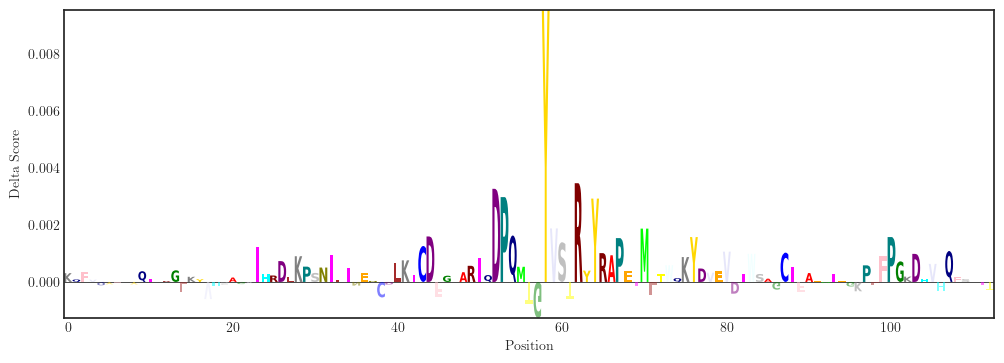

In [75]:
import matplotlib.pyplot as plt
import logomaker

# Plot!

delta_scores = np.array(average_scores_df['delta_lipnorm']).astype(np.float32)
sequence = sequence_trim

# Create an empty DataFrame
logo_df = pd.DataFrame({
    'letter': list(sequence),
    'delta': delta_scores
})

data = {'letter': list(sequence), 'delta': delta_scores}
logo_df = pd.DataFrame(data)

logo_df['delta'] = pd.to_numeric(logo_df['delta'], errors='coerce')

logo_df.dropna(inplace=True)

unique_symbols = set(sequence)
full_matrix = pd.DataFrame(0.0, index=np.arange(len(logo_df)), columns=unique_symbols)
for i, (letter, score) in enumerate(zip(logo_df['letter'], logo_df['delta'])):
    if letter in full_matrix.columns:
        full_matrix.at[i, letter] = score
plt.figure(figsize=(40, 6))

color_dict = {
    'A': 'red', 
    'C': 'blue', 
    'G': 'green', 
    'T': 'yellow',
    'D': 'purple',
    'E': 'orange',
    'F': 'pink',
    'H': 'cyan',
    'I': 'magenta',
    'K': 'gray',
    'L': 'brown',
    'M': 'lime',
    'N': 'olive',
    'P': 'teal',
    'Q': 'navy',
    'R': 'maroon',
    'S': 'silver',
    'V': 'lavender',
    'W': 'azure',
    'Y': 'gold'
}

# Create the logo
fig, ax = plt.subplots(figsize=(12, 4))

logo = logomaker.Logo(full_matrix, color_scheme=color_dict, fade_below=0.5, ax=ax)
ax.set_xlabel('Position')
ax.set_ylabel('Delta Score')

plt.margins(y=0.2)

plt.show()

pdf_file_path = './data/mutation_P32485.pdf'
with PdfPages(pdf_file_path) as pdf:
    pdf.savefig(fig)
    plt.close(fig)

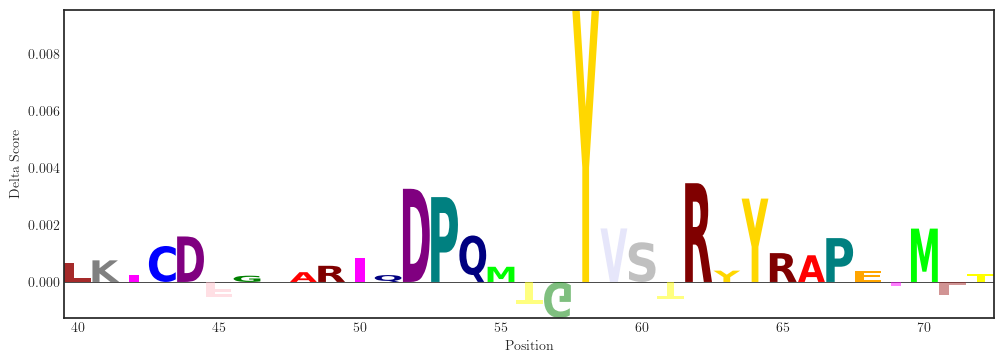

In [76]:
import matplotlib.pyplot as plt
import logomaker

# Plot!

delta_scores = np.array(average_scores_df['delta_lipnorm']).astype(np.float32)
sequence = sequence_trim

# Create an empty DataFrame
logo_df = pd.DataFrame({
    'letter': list(sequence),
    'delta': delta_scores
})

data = {'letter': list(sequence), 'delta': delta_scores}
logo_df = pd.DataFrame(data)

logo_df['delta'] = pd.to_numeric(logo_df['delta'], errors='coerce')

logo_df.dropna(inplace=True)

unique_symbols = set(sequence)
full_matrix = pd.DataFrame(0.0, index=np.arange(len(logo_df)), columns=unique_symbols)
for i, (letter, score) in enumerate(zip(logo_df['letter'], logo_df['delta'])):
    if letter in full_matrix.columns:
        full_matrix.at[i, letter] = score
        
color_dict = {
    'A': 'red', 
    'C': 'blue', 
    'G': 'green', 
    'T': 'yellow',
    'D': 'purple',
    'E': 'orange',
    'F': 'pink',
    'H': 'cyan',
    'I': 'magenta',
    'K': 'gray',
    'L': 'brown',
    'M': 'lime',
    'N': 'olive',
    'P': 'teal',
    'Q': 'navy',
    'R': 'maroon',
    'S': 'silver',
    'V': 'lavender',
    'W': 'azure',
    'Y': 'gold'
}


segment_matrix = full_matrix[40:73]
# Create the logo
fig, ax = plt.subplots(figsize=(12, 4))  

logo = logomaker.Logo(segment_matrix, color_scheme=color_dict, fade_below=0.5, ax=ax)
ax.set_xlabel('Position')
ax.set_ylabel('Delta Score')

plt.margins(y=0.2)

plt.show()

pdf_file_path = './data/mutation_P32485_focused.pdf'
with PdfPages(pdf_file_path) as pdf:
    pdf.savefig(fig)
    plt.close(fig)